In [2]:
import numpy as np
from sklearn.svm import LinearSVC
from sklearn.model_selection import KFold
from sklearn.datasets import make_classification
from timerun import time_code, time_func
import time
import matplotlib.pyplot as plt
import numpy as np
from multiprocessing import Pool
from parallel_methods import DSMethods

In [3]:
def plot_train_vs_test(train_scores, test_scores, spoint = None, wo = None, points = {}, time = -1, tvar = -1):
    if points != {}: plt.scatter(points.keys(), points.values(), marker='|', zorder = 3)
    plt.plot(train_scores.keys(), train_scores.values(), label = "Train", zorder = 2)
    plt.plot(test_scores.keys(), test_scores.values(), label = "Test", zorder = 1)
    
    xleft, xright = plt.xlim()
    if spoint and wo:
        plt.scatter(spoint[0], spoint[1], s=10, c='red')
        w = [-wo[1]/n_features, wo[0]]
        b = w[0]*spoint[0] + w[1]*spoint[1]
        xleft, xright = plt.xlim()
        xd = np.array([xleft, xright])
        yd = [(b - w[0]*xd[0]) / w[1], (b - w[0]*xd[1]) / w[1]]
        plt.plot(xd, yd, lw=1, c='red')
    
    plt.legend()
    plt.ylim([0.0,1.0])
    plt.xlim([xleft, xright])
    plt.axhline(0.1, color = "red", linewidth=1, linestyle="--")

    plt.show()

    print("AT", spoint, "WITH", len(points), "ITERATIONS IN", time, "SECONDS :", tvar)

def scal(data, w):
    obj = np.array([w[0] * (1 - acc) + w[1] * (i / n_features) for i, acc in data.items()])
    spoint_x = list(data.keys())[np.argmin(obj)]
    spoint_y = data[spoint_x]
    return (spoint_x, spoint_y, obj[np.argmin(obj)])

def mean_of_arrays(data):
    arr = {}
    for x in data[0]:
        arr[x] = np.mean([data[v][x] for v in data])
    return arr

def var_of_arrays(data):
    arr = {}
    for x in data[0]:
        arr[x] = np.var([data[v][x] for v in data])
    return arr

In [4]:
n_features = 100
X, y = make_classification(n_clusters_per_class = 1, n_classes=10, n_samples = 4000, n_features = n_features, n_informative = 20, random_state=8, flip_y= 0.01)
X_train, X_test = np.split(X, [1000])
y_train, y_test = np.split(y, [1000])
data = DSMethods(n_features, X_train, y_train, X_test, y_test)

# Random selection

In [5]:
@time_func
def RANDOM_SELECTION(CVal = 0.1, kernel='liblinear', w1 = [0.8, 0.2]):
    data.kernel = kernel
    data.C = CVal
    with Pool(7) as pool:
        scores = pool.map(data.randomSelection, [CVal]*10)
    
    #scores = list(map(data.randomSelection, [0.1]))

    train_scores = mean_of_arrays({i: x[0] for i, x in enumerate(scores)})
    test_scores  = mean_of_arrays({i: x[1] for i, x in enumerate(scores)})
    time         = np.mean([x[2] for x in scores])
    plot_train_vs_test(train_scores, test_scores, scal(test_scores, w1), w1)

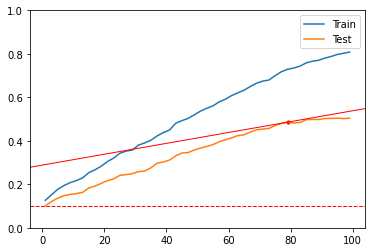

AT (79, 0.48579999999999995, 0.5693600000000001) WITH 0 ITERATIONS IN -1 SECONDS : -1
__main__.RANDOM_SELECTION - 00:00:08.773622900


In [6]:
RANDOM_SELECTION(1)

# SVM-RFE

In [7]:
@time_func
def SVM_RFE_W_STEP(mmode = 'const', step = 10, percentage = 0.5, C = 0.5, kernel = 'liblinear', w1 = [0.8, 0.2], gamma = 1.0, degree=6, mode='l1'):
    data.kernel = kernel
    #data.kernel_matrix = kernel
    data.C = C
    data.gamma = gamma
    data.degree = degree
    data.mode = mode
    kf = KFold(n_splits=18, shuffle=True)

    if mmode == 'const':
        index = [(train_index, test_index, step) for train_index, test_index in kf.split(data.X_train)]
        with Pool(7) as pool:
            scores = pool.map(data.svm_rfe_vanilla, index)
    if mmode == 'multi':
        index = [(train_index, test_index, step) for train_index, test_index in kf.split(data.X_train)]
        with Pool(7) as pool:
            scores = pool.map(data.svm_rfe_multi, index)

    #scores = list(map(data.svm_rfe_dynamic_step, index))
    scores = list(scores)

    train_scores = mean_of_arrays({i: x[0] for i, x in enumerate(scores)})
    test_scores  = mean_of_arrays({i: x[1] for i, x in enumerate(scores)})
    #points       = mean_of_arrays({i: x[2] for i, x in enumerate(scores)})
    points = {}
    time         = np.mean([x[3] for x in scores])
    tvar         = np.var([x[3] for x in scores])

    all_scores = [scal(x[1], w1)[2] for x in scores]
    err = np.std(all_scores, ddof=1) / np.sqrt(np.size(all_scores))
    print(np.mean(all_scores), err)

    print(mode, C, step)
    plot_train_vs_test(train_scores, test_scores, scal(test_scores, w1), w1, points, time, tvar)
    return scal(test_scores, w1), (np.mean(all_scores), err), time

0.32364790764790763 0.00931104971156837
l1 0.05 2


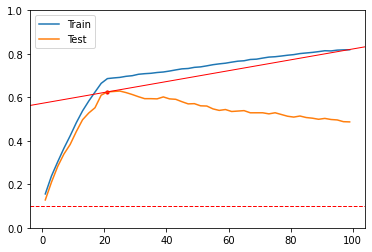

AT (21, 0.6249639249639249, 0.34202886002886007) WITH 0 ITERATIONS IN 4.0490976042217675 SECONDS : 0.08466587886339694
__main__.SVM_RFE_W_STEP - 00:00:23.090605200
0.3157777777777778 0.00882055569974865
l2 0.05 2


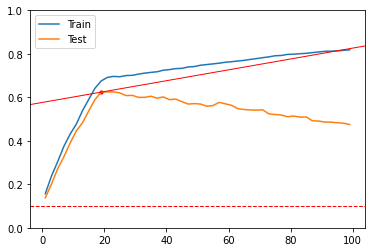

AT (19, 0.6239538239538239, 0.33883694083694094) WITH 0 ITERATIONS IN 4.074704077508715 SECONDS : 0.05944391109665767
__main__.SVM_RFE_W_STEP - 00:00:23.548510700
0.3217720057720058 0.01019700612764454
l3 0.05 2


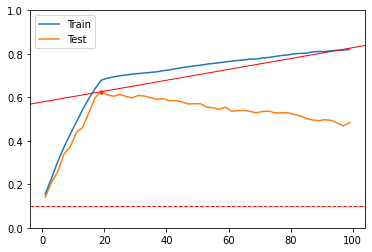

AT (19, 0.6259740259740261, 0.3372207792207792) WITH 0 ITERATIONS IN 4.601235111554463 SECONDS : 0.1624327139385934
__main__.SVM_RFE_W_STEP - 00:00:26.321601300
0.39234343434343444 0.011770056893870121
coef 0.05 2


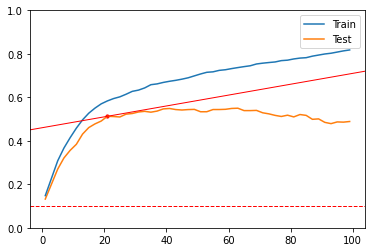

AT (21, 0.5128066378066377, 0.43175468975468984) WITH 0 ITERATIONS IN 4.994558413823445 SECONDS : 0.23152205214680383
__main__.SVM_RFE_W_STEP - 00:00:27.137676400
0.32872438672438675 0.010642697284335497
l1 0.1 2


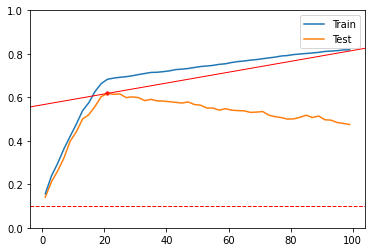

AT (21, 0.6180735930735931, 0.34754112554112554) WITH 0 ITERATIONS IN 4.925356308619182 SECONDS : 0.1331273276578347
__main__.SVM_RFE_W_STEP - 00:00:26.811868200
0.3214430014430015 0.011635409280315943
l2 0.1 2


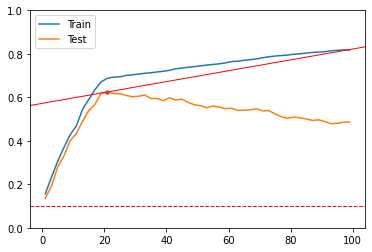

AT (21, 0.6248015873015872, 0.3421587301587303) WITH 0 ITERATIONS IN 4.896031671100193 SECONDS : 0.23086918577129756
__main__.SVM_RFE_W_STEP - 00:00:26.477494100
0.3201673881673882 0.01164905785751252
l3 0.1 2


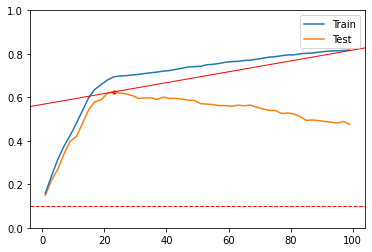

AT (23, 0.6249819624819625, 0.34601443001443005) WITH 0 ITERATIONS IN 4.893969575564067 SECONDS : 0.1309694490470687
__main__.SVM_RFE_W_STEP - 00:00:26.768946200
0.38658874458874465 0.014174034222723737
coef 0.1 2


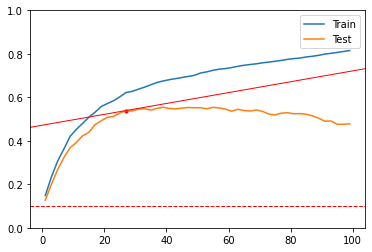

AT (27, 0.5392316017316018, 0.4226147186147186) WITH 0 ITERATIONS IN 5.806341913011339 SECONDS : 0.3928826661483709
__main__.SVM_RFE_W_STEP - 00:00:30.966344300
0.3276017316017316 0.008705522034582058
l1 0.2 2


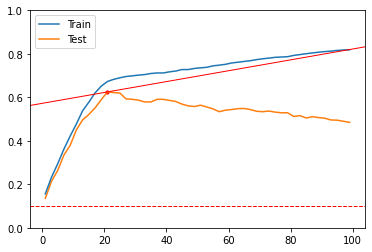

AT (21, 0.6248737373737373, 0.3421010101010102) WITH 0 ITERATIONS IN 5.6334912114673195 SECONDS : 0.12198821589297751
__main__.SVM_RFE_W_STEP - 00:00:29.595652400
0.3272900432900433 0.013178941524082844
l2 0.2 2


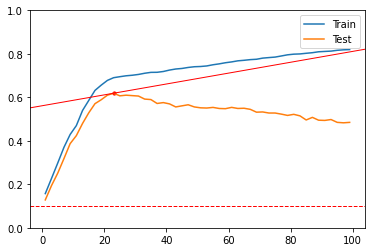

AT (23, 0.6188672438672439, 0.3509062049062049) WITH 0 ITERATIONS IN 5.602600375811259 SECONDS : 0.12770906429385637
__main__.SVM_RFE_W_STEP - 00:00:29.601774200
0.347004329004329 0.010085930223187755
l3 0.2 2


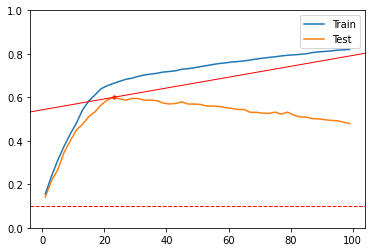

AT (23, 0.6001803751803751, 0.3658556998556999) WITH 0 ITERATIONS IN 5.730035463968913 SECONDS : 0.12126714364873376
__main__.SVM_RFE_W_STEP - 00:00:30.543269200
0.3889408369408369 0.011386512834833528
coef 0.2 2


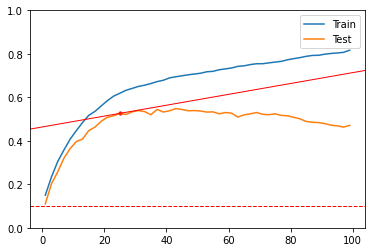

AT (25, 0.5262085137085135, 0.4290331890331892) WITH 0 ITERATIONS IN 6.508898960219489 SECONDS : 0.30601074914192344
__main__.SVM_RFE_W_STEP - 00:00:32.691142600
0.3356969696969697 0.010520128330682672
l1 0.5 2


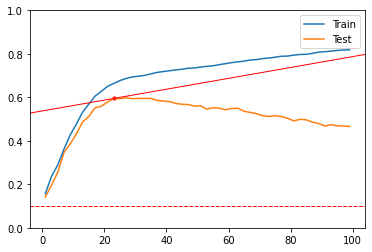

AT (23, 0.5948412698412698, 0.37012698412698414) WITH 0 ITERATIONS IN 6.405049377017551 SECONDS : 0.1055184696099177
__main__.SVM_RFE_W_STEP - 00:00:32.027383900
0.3454718614718615 0.011575883279807207
l2 0.5 2


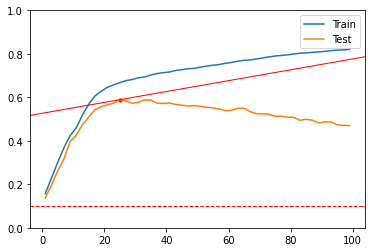

AT (25, 0.5892135642135643, 0.3786291486291486) WITH 0 ITERATIONS IN 6.306582278675503 SECONDS : 0.14112521427456393
__main__.SVM_RFE_W_STEP - 00:00:30.952508100
0.39016738816738816 0.00795276574807682
l3 0.5 2


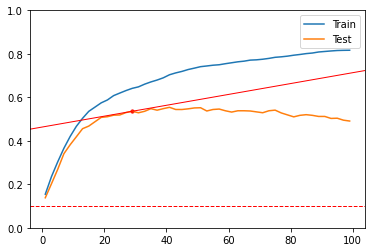

AT (29, 0.535894660894661, 0.4292842712842712) WITH 0 ITERATIONS IN 6.838743103875054 SECONDS : 0.4480456579842428
__main__.SVM_RFE_W_STEP - 00:00:32.755363700
0.3914227994227994 0.011353950846976177
coef 0.5 2


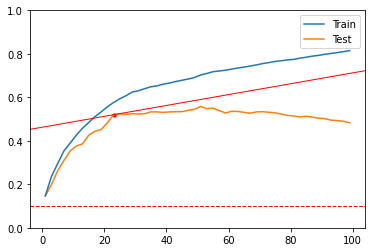

AT (23, 0.520093795093795, 0.429924963924964) WITH 0 ITERATIONS IN 8.636390937699211 SECONDS : 0.6932485805787582
__main__.SVM_RFE_W_STEP - 00:00:39.689000400
0.3446204906204906 0.013120085716612561
l1 1 2


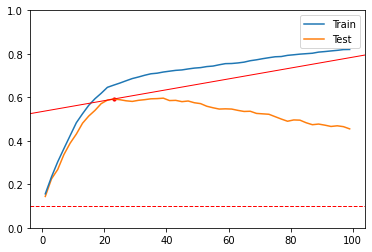

AT (23, 0.5922258297258298, 0.37221933621933617) WITH 0 ITERATIONS IN 7.538598047362433 SECONDS : 0.23586987543612267
__main__.SVM_RFE_W_STEP - 00:00:34.954227600
0.3669119769119769 0.009129547169758612
l2 1 2


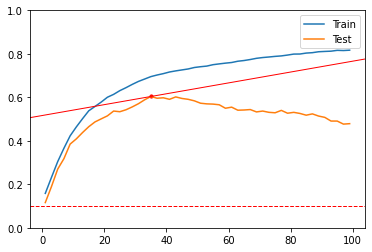

AT (35, 0.6038600288600288, 0.38691197691197704) WITH 0 ITERATIONS IN 8.196326560444302 SECONDS : 0.46736238377111483
__main__.SVM_RFE_W_STEP - 00:00:36.543174400
0.39527849927849934 0.01129357041588352
l3 1 2


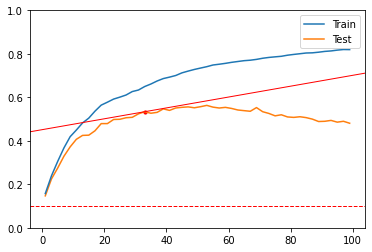

AT (33, 0.5338383838383839, 0.4389292929292929) WITH 0 ITERATIONS IN 8.42084965440962 SECONDS : 0.4120129594535288
__main__.SVM_RFE_W_STEP - 00:00:37.172506300
0.4055497835497836 0.012655680737586768
coef 1 2


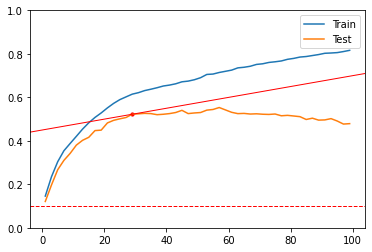

AT (29, 0.5222402597402599, 0.4402077922077921) WITH 0 ITERATIONS IN 12.753187868330214 SECONDS : 3.949042561268975
__main__.SVM_RFE_W_STEP - 00:00:49.511792500
0.34216450216450217 0.013292912283259248
l1 2 2


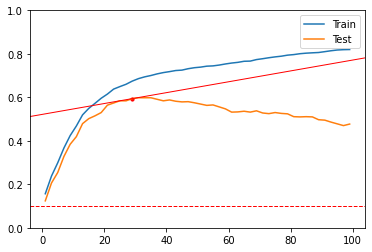

AT (29, 0.5940476190476189, 0.38276190476190486) WITH 0 ITERATIONS IN 9.935979723930359 SECONDS : 0.863297480432861
__main__.SVM_RFE_W_STEP - 00:00:41.075619300
0.38061471861471863 0.011764963833946469
l2 2 2


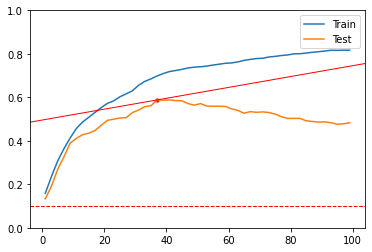

AT (37, 0.588095238095238, 0.4035238095238096) WITH 0 ITERATIONS IN 10.574869328074985 SECONDS : 0.8195006775861948
__main__.SVM_RFE_W_STEP - 00:00:43.011217300
0.4016421356421357 0.012259647384254049
l3 2 2


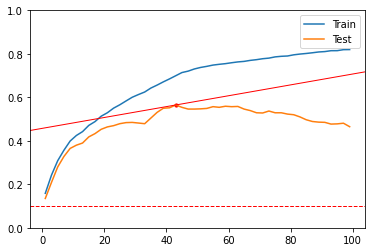

AT (43, 0.5648088023088023, 0.43415295815295823) WITH 0 ITERATIONS IN 11.827573895454407 SECONDS : 0.8627730457405723
__main__.SVM_RFE_W_STEP - 00:00:45.991368200
0.42207215007215004 0.009877981623912284
coef 2 2


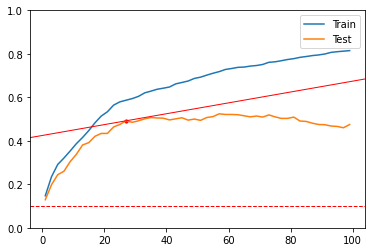

AT (27, 0.4920454545454547, 0.46036363636363625) WITH 0 ITERATIONS IN 18.76538172033098 SECONDS : 8.415526324360783
__main__.SVM_RFE_W_STEP - 00:01:08.631018400


In [8]:
model_selection = {}
for C in [0.05, 0.1, 0.2, 0.5, 1, 2]:
    for mode in ['l1', 'l2', 'l3', 'coef']:
        model_selection[C, mode] = SVM_RFE_W_STEP('multi', C=C, step=2, mode=mode)

In [11]:
lines = {}
for C, d in model_selection:
    lines[C] = ['\\textbf{' + "{:.2f}".format(C) + '}', '', '', '']

for C, d in model_selection:
    col = {'l1': 1, 'l2': 2, 'l3': 3}
    if d in col.keys():
        v = model_selection[C, d]
        lines[C][col[d]] = "  {:>3s} & {:.2f}\\% & {:.3f} $\\pm$ {:.3f}".format(str(v[0][0]), 100 * v[0][1], v[1][0], v[1][1])

for line in lines.values():
    print(' & '.join(line) + '\\\\')

\textbf{0.05} &    21 & 62.50\% & 0.324 $\pm$ 0.009 &    19 & 62.40\% & 0.316 $\pm$ 0.009 &    19 & 62.60\% & 0.322 $\pm$ 0.010\\
\textbf{0.10} &    21 & 61.81\% & 0.329 $\pm$ 0.011 &    21 & 62.48\% & 0.321 $\pm$ 0.012 &    23 & 62.50\% & 0.320 $\pm$ 0.012\\
\textbf{0.20} &    21 & 62.49\% & 0.328 $\pm$ 0.009 &    23 & 61.89\% & 0.327 $\pm$ 0.013 &    23 & 60.02\% & 0.347 $\pm$ 0.010\\
\textbf{0.50} &    23 & 59.48\% & 0.336 $\pm$ 0.011 &    25 & 58.92\% & 0.345 $\pm$ 0.012 &    29 & 53.59\% & 0.390 $\pm$ 0.008\\
\textbf{1.00} &    23 & 59.22\% & 0.345 $\pm$ 0.013 &    35 & 60.39\% & 0.367 $\pm$ 0.009 &    33 & 53.38\% & 0.395 $\pm$ 0.011\\
\textbf{2.00} &    29 & 59.40\% & 0.342 $\pm$ 0.013 &    37 & 58.81\% & 0.381 $\pm$ 0.012 &    43 & 56.48\% & 0.402 $\pm$ 0.012\\


In [10]:
lines = {}
for C, d in model_selection:
    lines[C] = ['\\textbf{' + "{:.6f}".format(C) + '}', '', '', '']

for C, d in model_selection:
    col = {'l1': 1, 'l2': 2, 'coef': 3}
    if d in col.keys():
        v = model_selection[C, d]
        lines[C][col[d]] = "{:.0f}:{:0>2s}.{:0>3s}".format(v[1]/60, str(int(v[1] % 60)), str(int((v[1] % 1) * 1000)))

for line in lines.values():
    print(' & '.join(line) + '\\\\')

TypeError: unsupported operand type(s) for /: 'tuple' and 'int'